<a href="https://colab.research.google.com/github/bonnefco/P8/blob/main/P8_EDA_TF_IDF_MODELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import ast
from scipy import stats

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [57]:
df_effective_args = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/P8/dataset/train_light.csv',encoding="utf-8",header=(0))

# Fonctions utiles

In [58]:
def create_histogram_of_words(list_of_words):

  dictionnaire_words = dict(nltk.FreqDist(list_of_words))
  somme_total_occurences = sum(dictionnaire_words.values())

  dictionnaire_pourcentage_words = dictionnaire_words.copy()

  for key, value in dictionnaire_pourcentage_words.items():
    dictionnaire_pourcentage_words[key] = dictionnaire_pourcentage_words[key]/somme_total_occurences

  dictionnaire_trie_pourcentage_words = dict(sorted(dictionnaire_pourcentage_words.items(), key=lambda item: item[1] ,reverse=True))
  dictionnaire_values_words = list(dictionnaire_trie_pourcentage_words.values())

  liste_value_cumul_words = []
  somme_cumulee = 0

  for valeurs in dictionnaire_values_words : 
    somme_cumulee = somme_cumulee + valeurs
    liste_value_cumul_words.append(somme_cumulee)

  return liste_value_cumul_words 

# Nettoyage pour approche TF-IDF

## Creation des premiers tokens (longueur > 1) et passage en minuscule

In [59]:
def create_token(string):
  tokenizer = nltk.RegexpTokenizer(r'\w+')
  string = tokenizer.tokenize(string.lower())
  list_tokens_elements = [element for element in string if len(element)>1]
  return list_tokens_elements

In [60]:
df_effective_args['discourse_text_tokenized'] = df_effective_args['discourse_text'].apply(create_token)

In [61]:
df_effective_args.head(2)

,discourse_text,discourse_type,discourse_effectiveness,discourse_text_tokenized
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"[hi, isaac, going, to, be, writing, about, how..."
1,"On my perspective, I think that the face is a ...",Position,Adequate,"[on, my, perspective, think, that, the, face, ..."


## La lemmantization 

In [62]:
lemmatizer = WordNetLemmatizer()

In [63]:
def create_lemmatization(list_of_words_tokenized) :
  list_of_words_tokenized_lemmantized = []
  for token in list_of_words_tokenized:
    lemmetized_word = lemmatizer.lemmatize(token)
    if len(lemmetized_word) > 1 : 
      list_of_words_tokenized_lemmantized.append(lemmetized_word)
  return list_of_words_tokenized_lemmantized

In [64]:
df_effective_args['discourse_text_lemmatized'] = df_effective_args['discourse_text_tokenized'].apply(create_lemmatization)

In [65]:
df_effective_args

,discourse_text,discourse_type,discourse_effectiveness,discourse_text_tokenized,discourse_text_lemmatized
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"[hi, isaac, going, to, be, writing, about, how...","[hi, isaac, going, to, be, writing, about, how..."
1,"On my perspective, I think that the face is a ...",Position,Adequate,"[on, my, perspective, think, that, the, face, ...","[on, my, perspective, think, that, the, face, ..."
2,I think that the face is a natural landform be...,Claim,Adequate,"[think, that, the, face, is, natural, landform...","[think, that, the, face, is, natural, landform..."
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"[if, life, was, on, mars, we, would, know, by,...","[if, life, wa, on, mar, we, would, know, by, n..."
4,People thought that the face was formed by ali...,Counterclaim,Adequate,"[people, thought, that, the, face, was, formed...","[people, thought, that, the, face, wa, formed,..."
...,...,...,...,...,...
36672,For many people they don't like only asking on...,Claim,Adequate,"[for, many, people, they, don, like, only, ask...","[for, many, people, they, don, like, only, ask..."
36673,also people have different views and opinions ...,Claim,Adequate,"[also, people, have, different, views, and, op...","[also, people, have, different, view, and, opi..."
36674,Advice is something that can impact a persons ...,Position,Adequate,"[advice, is, something, that, can, impact, per...","[advice, is, something, that, can, impact, per..."
36675,someone can use everything that many people sa...,Evidence,Ineffective,"[someone, can, use, everything, that, many, pe...","[someone, can, use, everything, that, many, pe..."


### Limites : la lemmatisation tronque certains mots 
*   "mars" -> "mar" ...
*   "was" -> "wa"

## Nettoyage des Stop words

### Stop words (corpus et nltk)

In [66]:
list_all_words = [j for i in df_effective_args['discourse_text_lemmatized'].tolist() for j in i]
dictionnaire_des_frequences = nltk.FreqDist(list_all_words)

In [67]:
stop_words_corpus = []
nombre_de_mot_selectionne = 25
for i in range(0, nombre_de_mot_selectionne):
  stop_words_corpus.append(dictionnaire_des_frequences.most_common(nombre_de_mot_selectionne+1)[i][0])
stop_words_nltk = list(set(stopwords.words('english')))
stop_words_merged = list(set(stop_words_nltk+stop_words_corpus))

#### Liste des mots selectionnés

In [68]:
print(stop_words_corpus)

['the', 'to', 'and', 'of', 'that', 'it', 'in', 'is', 'they', 'for', 'you', 'be', 'student', 'have', 'are', 'not', 'on', 'can', 'this', 'people', 'would', 'if', 'or', 'their', 'with']


#### Suppression stop words corpus

In [69]:
def delete_stop_words_in_corpus(x, list_of_stop_words = stop_words_merged) :
  y = x.copy()
  for element in list_of_stop_words :
    while element in y: y.remove(element)
  return y

In [70]:
df_effective_args['no_stop_words'] = df_effective_args['discourse_text_lemmatized'].transform(delete_stop_words_in_corpus)

In [71]:
df_effective_args

,discourse_text,discourse_type,discourse_effectiveness,discourse_text_tokenized,discourse_text_lemmatized,no_stop_words
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"[hi, isaac, going, to, be, writing, about, how...","[hi, isaac, going, to, be, writing, about, how...","[hi, isaac, going, writing, face, mar, natural..."
1,"On my perspective, I think that the face is a ...",Position,Adequate,"[on, my, perspective, think, that, the, face, ...","[on, my, perspective, think, that, the, face, ...","[perspective, think, face, natural, landform, ..."
2,I think that the face is a natural landform be...,Claim,Adequate,"[think, that, the, face, is, natural, landform...","[think, that, the, face, is, natural, landform...","[think, face, natural, landform, life, mar, de..."
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"[if, life, was, on, mars, we, would, know, by,...","[if, life, wa, on, mar, we, would, know, by, n...","[life, wa, mar, know, reason, think, natural, ..."
4,People thought that the face was formed by ali...,Counterclaim,Adequate,"[people, thought, that, the, face, was, formed...","[people, thought, that, the, face, wa, formed,...","[thought, face, wa, formed, alieans, thought, ..."
...,...,...,...,...,...,...
36672,For many people they don't like only asking on...,Claim,Adequate,"[for, many, people, they, don, like, only, ask...","[for, many, people, they, don, like, only, ask...","[many, like, asking, one, person, advice, some..."
36673,also people have different views and opinions ...,Claim,Adequate,"[also, people, have, different, views, and, op...","[also, people, have, different, view, and, opi...","[also, different, view, opinion, thing]"
36674,Advice is something that can impact a persons ...,Position,Adequate,"[advice, is, something, that, can, impact, per...","[advice, is, something, that, can, impact, per...","[advice, something, impact, person, view, many..."
36675,someone can use everything that many people sa...,Evidence,Ineffective,"[someone, can, use, everything, that, many, pe...","[someone, can, use, everything, that, many, pe...","[someone, use, everything, many, said, use, he..."


## Selection des tokens à conserver

In [72]:
list_all_words = [j for i in df_effective_args['no_stop_words'].tolist() for j in i]

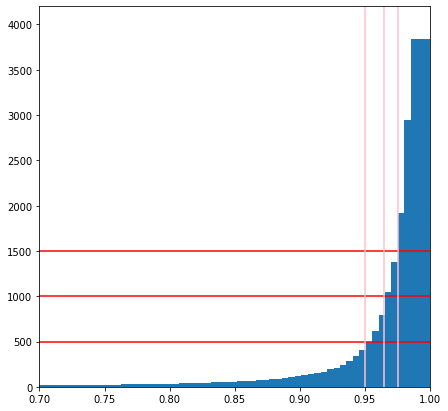

In [73]:
  plt.figure(figsize = (7,7))
  plt.ylim(0, 4200)
  plt.xlim(0.7, 1)
  plt.axhline(y = 1500, color='red')
  plt.axhline(y = 1000, color='red')
  plt.axhline(y = 500, color='red')
  plt.axvline(x = 0.95, color='pink')
  plt.axvline(x = 0.975, color='pink')
  plt.axvline(x = 0.965, color='pink')
  plt.hist(create_histogram_of_words(list_all_words), bins = 200)
  plt.show()

### D'après l'étude empirique, il semble que 2000 tokens soit un bon compromis

#### Conservation des 1000 tokens les plus fréquents

In [74]:
def delete_y_words(nb_words_to_save, liste_words):

  dictionnaire_des_frequences = nltk.FreqDist(liste_words)
  dictionnaire_des_frequences = dictionnaire_des_frequences.most_common(nb_words_to_save)
  words = []
  for i in range(0, nb_words_to_save):
    words.append(dictionnaire_des_frequences[i][0])

  return words

nb_words_to_save = 2000
liste_words_to_keep = delete_y_words(nb_words_to_save, list_all_words)

In [75]:
def delete_if_not_in(liste, liste_words_to_keep = liste_words_to_keep):

  words_in_list = [i for i in liste if i in liste_words_to_keep]

  return list(words_in_list)

In [76]:
df_effective_args['only_'+str(nb_words_to_save)+'_tokens'] = df_effective_args['no_stop_words'].apply(delete_if_not_in)

In [77]:
df_effective_args.head(6)

,discourse_text,discourse_type,discourse_effectiveness,discourse_text_tokenized,discourse_text_lemmatized,no_stop_words,only_2000_tokens
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"[hi, isaac, going, to, be, writing, about, how...","[hi, isaac, going, to, be, writing, about, how...","[hi, isaac, going, writing, face, mar, natural...","[going, writing, face, mar, natural, landform,..."
1,"On my perspective, I think that the face is a ...",Position,Adequate,"[on, my, perspective, think, that, the, face, ...","[on, my, perspective, think, that, the, face, ...","[perspective, think, face, natural, landform, ...","[perspective, think, face, natural, landform, ..."
2,I think that the face is a natural landform be...,Claim,Adequate,"[think, that, the, face, is, natural, landform...","[think, that, the, face, is, natural, landform...","[think, face, natural, landform, life, mar, de...","[think, face, natural, landform, life, mar, yet]"
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"[if, life, was, on, mars, we, would, know, by,...","[if, life, wa, on, mar, we, would, know, by, n...","[life, wa, mar, know, reason, think, natural, ...","[life, wa, mar, know, reason, think, natural, ..."
4,People thought that the face was formed by ali...,Counterclaim,Adequate,"[people, thought, that, the, face, was, formed...","[people, thought, that, the, face, wa, formed,...","[thought, face, wa, formed, alieans, thought, ...","[thought, face, wa, formed, thought, wa, life,..."
5,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective,"[though, some, say, that, life, on, mars, does...","[though, some, say, that, life, on, mar, doe, ...","[though, say, life, mar, doe, exist, think, li...","[though, say, life, mar, doe, exist, think, li..."


# Exploration univariée

In [78]:
def counter_len_in_text(string):
  return len(string)

In [79]:
df_effective_args['Longueur_texte'] = df_effective_args['only_'+str(nb_words_to_save)+'_tokens'].apply(counter_len_in_text)

In [80]:
df_effective_args.head(4)

,discourse_text,discourse_type,discourse_effectiveness,discourse_text_tokenized,discourse_text_lemmatized,no_stop_words,only_2000_tokens,Longueur_texte
0,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"[hi, isaac, going, to, be, writing, about, how...","[hi, isaac, going, to, be, writing, about, how...","[hi, isaac, going, writing, face, mar, natural...","[going, writing, face, mar, natural, landform,...",27
1,"On my perspective, I think that the face is a ...",Position,Adequate,"[on, my, perspective, think, that, the, face, ...","[on, my, perspective, think, that, the, face, ...","[perspective, think, face, natural, landform, ...","[perspective, think, face, natural, landform, ...",15
2,I think that the face is a natural landform be...,Claim,Adequate,"[think, that, the, face, is, natural, landform...","[think, that, the, face, is, natural, landform...","[think, face, natural, landform, life, mar, de...","[think, face, natural, landform, life, mar, yet]",7
3,"If life was on Mars, we would know by now. The...",Evidence,Adequate,"[if, life, was, on, mars, we, would, know, by,...","[if, life, wa, on, mar, we, would, know, by, n...","[life, wa, mar, know, reason, think, natural, ...","[life, wa, mar, know, reason, think, natural, ...",28


## Remplissage

In [81]:
print((100-100*(df_effective_args.isna().sum()/(df_effective_args.shape[0]))).sort_values(ascending=False))
print(df_effective_args.dtypes.value_counts())

discourse_text               100.0
discourse_type               100.0
discourse_effectiveness      100.0
discourse_text_tokenized     100.0
discourse_text_lemmatized    100.0
no_stop_words                100.0
only_2000_tokens             100.0
Longueur_texte               100.0
dtype: float64
object    7
int64     1
dtype: int64


## Description

In [82]:
df_effective_args.describe()

,Longueur_texte
count,36677.000000
mean,18.710282
std,19.640965
min,0.000000
25%,7.000000
50%,12.000000
75%,24.000000
max,333.000000


## Pie Chart

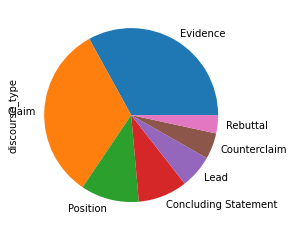

In [83]:
plt.figure()
df_effective_args['discourse_type'].value_counts().plot.pie()

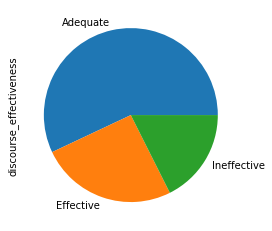

In [84]:
plt.figure()
df_effective_args['discourse_effectiveness'].value_counts().plot.pie()

## Distribution longueur du texte 

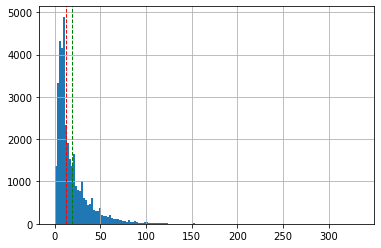

In [85]:
plt.figure()
df_effective_args['Longueur_texte'].hist(bins=150)
plt.axvline(df_effective_args['Longueur_texte'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(df_effective_args['Longueur_texte'].median(), color='r', linestyle='dashed', linewidth=1)
plt.show()

# Exploration multivariée

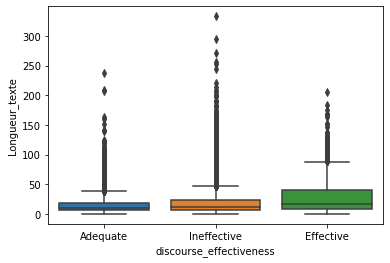

In [86]:
plt.figure()
sns.boxplot(y=df_effective_args['Longueur_texte'], x=df_effective_args['discourse_effectiveness'])
plt.show()

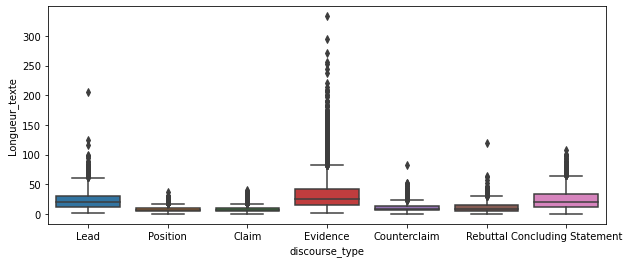

In [87]:
plt.figure(figsize=(10, 4))
sns.boxplot(y=df_effective_args['Longueur_texte'], x=df_effective_args['discourse_type'])
plt.show()

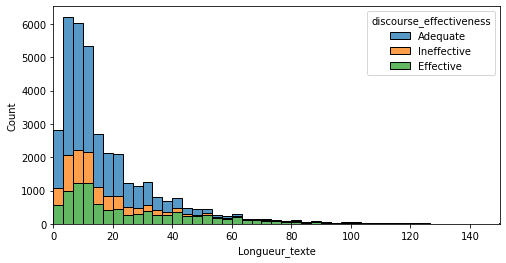

<Figure size 576x288 with 0 Axes>

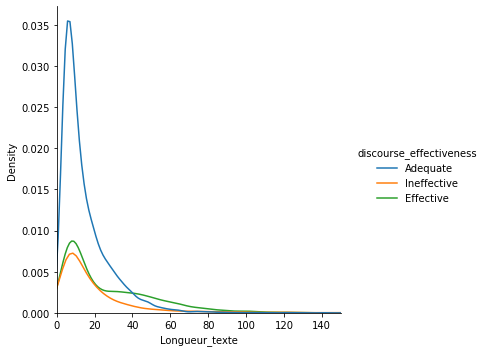

In [88]:
plt.figure(figsize=(8, 4))
plt.xlim(0, 150)
sns.histplot(data=df_effective_args, x=df_effective_args['Longueur_texte'], hue=df_effective_args['discourse_effectiveness'], bins=100, multiple="stack")
plt.show()

plt.figure(figsize=(8, 4))
sns.displot(data=df_effective_args, x=df_effective_args['Longueur_texte'], hue=df_effective_args['discourse_effectiveness'], kind="kde")
plt.xlim(0, 150)
plt.show()

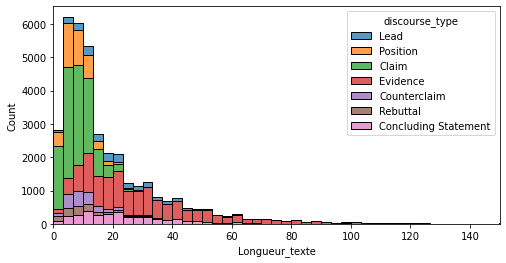

<Figure size 576x288 with 0 Axes>

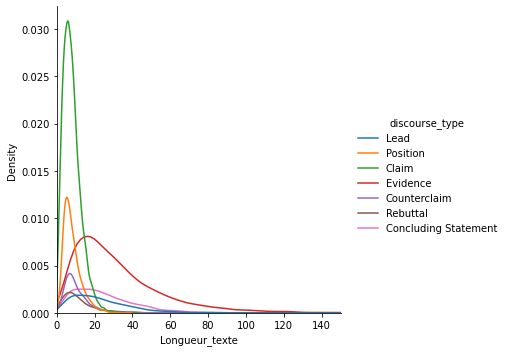

In [89]:
plt.figure(figsize=(8, 4))
plt.xlim(0, 150)
sns.histplot(data=df_effective_args, x=df_effective_args['Longueur_texte'], hue=df_effective_args['discourse_type'], bins=100, multiple="stack")
plt.show()

plt.figure(figsize=(8, 4))
sns.displot(data=df_effective_args, x=df_effective_args['Longueur_texte'], hue=df_effective_args['discourse_type'], kind="kde")
plt.xlim(0, 150)
plt.show()

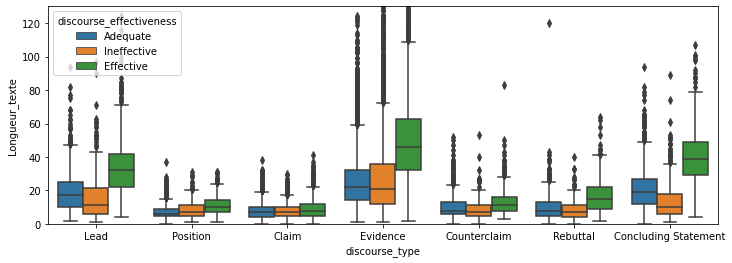

In [90]:
plt.figure(figsize=(12, 4))
plt.ylim(0, 130)
sns.boxplot(y=df_effective_args['Longueur_texte'], x=df_effective_args['discourse_type'] ,hue=df_effective_args['discourse_effectiveness'])
plt.show()

# Feature Engineering

## Suppression des longueurs supérieures à 150

In [91]:
df_effective_args = df_effective_args[df_effective_args['Longueur_texte']<150]

## Concatenation colonnes type et contenu 

In [92]:
df_effective_args['type_and_tokens'] = df_effective_args['discourse_type'].map(lambda i: [i]) + df_effective_args['only_'+str(nb_words_to_save)+'_tokens']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Méthode TF-IDF

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, classification_report, plot_roc_curve
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

import joblib
import ast
import time

!cp /content/drive/MyDrive/Open_classrooms/P2/pca_file.py .
import pca_file

from sklearn.linear_model import LogisticRegression

In [94]:
X_train, X_test, y_train, y_test = train_test_split(df_effective_args['type_and_tokens'], df_effective_args['discourse_effectiveness'], test_size=0.2, random_state=1)

### Separation et preparation train set et test set

In [95]:
list_words = X_train.tolist()
list_corpus = []
for element in list_words :
  list_corpus.append(' '.join(element))
tfidftvecto =  TfidfVectorizer()
tfidf_model = tfidftvecto.fit(list_corpus)
tfidf_tokens = tfidftvecto.get_feature_names_out()
X_train_encoded = pd.DataFrame(data = tfidftvecto.fit_transform(list_corpus).toarray(),columns = tfidf_tokens)

In [96]:
list_words_test = X_test.tolist()
list_corpus_test = []
for element in list_words_test :
  list_corpus_test.append(' '.join(element))
X_test_encoded = pd.DataFrame(data = tfidf_model.transform(list_corpus_test).toarray(),columns = tfidf_tokens)

In [97]:
lb = LabelBinarizer()
df_labels_train = pd.DataFrame(lb.fit_transform(y_train), columns=lb.classes_)
df_labels_test = pd.DataFrame(lb.fit_transform(y_test), columns=lb.classes_)

# Modelisation

In [98]:
!cp /content/drive/MyDrive/Open_classrooms/P2/pca_file.py .
import pca_file

n_components =  20 pourcentage 0.05322601960372108


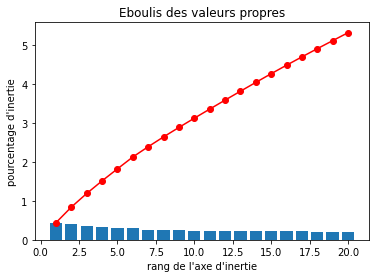

In [99]:
n_components=20
numerical_features = list(X_train_encoded.select_dtypes(['int']).columns)+list(X_train_encoded.select_dtypes(['float']).columns)
numerical_pipeline = make_pipeline(StandardScaler())
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))
model = make_pipeline(preprocessor, PCA(n_components))
model_all_features_PCA = model.fit(X_train_encoded)
model_all_features_PCA[1].explained_variance_ratio_
print('n_components = ', n_components, 'pourcentage', sum(model_all_features_PCA[1].explained_variance_ratio_))

pca_file.display_scree_plot(model_all_features_PCA[1])

## DummyClassifier

In [100]:
numerical_features = list(X_train_encoded.select_dtypes(['int']).columns)+list(X_train_encoded.select_dtypes(['float']).columns)

numerical_pipeline = make_pipeline(StandardScaler())
multilabel_classifier = OneVsRestClassifier(DummyClassifier( strategy = 'prior'))
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))
model_dum = make_pipeline(preprocessor, multilabel_classifier)

start_time_fit = time.time()
model_dum.fit(X_train_encoded, df_labels_train)

elapsed_time_fit = time.time() - start_time_fit #time

start_time_predict = time.time()
df_labels_pred = model_dum.predict(X_test_encoded)
df_labels_pred_proba = model_dum.predict_proba(X_test_encoded)

elapsed_time_predict = time.time() - start_time_predict #time
print(elapsed_time_fit, elapsed_time_predict) #time

print(classification_report(df_labels_test, df_labels_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


1.290783405303955 0.3666050434112549
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      4161
           1       0.00      0.00      0.00      1882
           2       0.00      0.00      0.00      1280

   micro avg       0.57      0.57      0.57      7323
   macro avg       0.19      0.33      0.24      7323
weighted avg       0.32      0.57      0.41      7323
 samples avg       0.57      0.57      0.57      7323



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RandomForest

In [101]:
numerical_features = list(X_train_encoded.select_dtypes(['int']).columns)+list(X_train_encoded.select_dtypes(['float']).columns)
numerical_pipeline = make_pipeline(StandardScaler())

R_F = RandomForestClassifier()
multilabel_classifier = OneVsRestClassifier(R_F)
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))
model_R_F = make_pipeline(preprocessor, multilabel_classifier)

start_time_fit = time.time()
model_R_F.fit(X_train_encoded, df_labels_train)

elapsed_time_fit = time.time() - start_time_fit #time

start_time_predict = time.time()
df_labels_pred = model_R_F.predict(X_test_encoded)
df_labels_pred_proba = model_R_F.predict_proba(X_test_encoded)

elapsed_time_predict = time.time() - start_time_predict #time
print(elapsed_time_fit, elapsed_time_predict) #time

print(classification_report(df_labels_test, df_labels_pred))

342.7569966316223 6.738645792007446
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      4161
           1       0.74      0.34      0.47      1882
           2       0.59      0.10      0.17      1280

   micro avg       0.67      0.57      0.61      7323
   macro avg       0.66      0.42      0.46      7323
weighted avg       0.67      0.57      0.56      7323
 samples avg       0.56      0.57      0.56      7323



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Regression logistic

### OneVsRest

In [102]:
numerical_features = list(X_train_encoded.select_dtypes(['int']).columns)+list(X_train_encoded.select_dtypes(['float']).columns)
numerical_pipeline = make_pipeline(StandardScaler())

L_R = LogisticRegression(max_iter= 1000)
multilabel_classifier = OneVsRestClassifier(L_R)
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))
model_L_R = make_pipeline(preprocessor, multilabel_classifier)

start_time_fit = time.time()
model_L_R.fit(X_train_encoded, df_labels_train)

elapsed_time_fit = time.time() - start_time_fit #time

start_time_predict = time.time()
df_labels_pred = model_L_R.predict(X_test_encoded)
df_labels_pred_proba = model_L_R.predict_proba(X_test_encoded)

elapsed_time_predict = time.time() - start_time_predict #time
print(elapsed_time_fit, elapsed_time_predict) #time

print(classification_report(df_labels_test, df_labels_pred))

51.70269060134888 0.5013308525085449
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      4161
           1       0.67      0.49      0.57      1882
           2       0.46      0.23      0.31      1280

   micro avg       0.64      0.60      0.62      7323
   macro avg       0.59      0.49      0.53      7323
weighted avg       0.62      0.60      0.60      7323
 samples avg       0.57      0.60      0.58      7323



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Optimisation One Versus Rest

In [103]:
parameters = {
    "onevsrestclassifier__estimator__max_iter": [800, 1000, 1200, 1500]
}

In [104]:
numerical_features = list(X_train_encoded.select_dtypes(['int']).columns)+list(X_train_encoded.select_dtypes(['float']).columns)
numerical_pipeline = make_pipeline(StandardScaler())

L_R = LogisticRegression()

multilabel_classifier = OneVsRestClassifier(L_R)
preprocessor = make_column_transformer((numerical_pipeline, numerical_features))
model_L_R = make_pipeline(preprocessor, multilabel_classifier)

grid_L_R = GridSearchCV(model_L_R, param_grid = parameters, cv=5)

start_time_fit = time.time()
grid_L_R.fit(X_train_encoded, df_labels_train)
print('meilleurs parametres : ', grid_L_R.best_params_)
elapsed_time_fit = time.time() - start_time_fit #time

start_time_predict = time.time()
df_labels_pred = grid_L_R.predict(X_test_encoded)
df_labels_pred_proba = grid_L_R.predict_proba(X_test_encoded)

elapsed_time_predict = time.time() - start_time_predict #time
print(elapsed_time_fit, elapsed_time_predict) #time

print(classification_report(df_labels_test, df_labels_pred))

meilleurs parametres :  {'onevsrestclassifier__estimator__max_iter': 800}
968.0824875831604 0.6572773456573486
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      4161
           1       0.67      0.49      0.57      1882
           2       0.46      0.23      0.31      1280

   micro avg       0.64      0.60      0.62      7323
   macro avg       0.59      0.49      0.53      7323
weighted avg       0.62      0.60      0.60      7323
 samples avg       0.57      0.60      0.58      7323



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction

In [105]:
def pipeline_from_dataset_to_tokens(df, nb_words_to_save):
  df['discourse_text_tokenized'] = df['discourse_text'].apply(create_token)
  df['discourse_text_lemmatized'] = df['discourse_text_tokenized'].apply(create_lemmatization)
  df['no_stop_words'] = df['discourse_text_lemmatized'].transform(delete_stop_words_in_corpus)
  df['only_'+str(nb_words_to_save)+'_tokens'] = df['no_stop_words'].apply(delete_if_not_in)
  df['Longueur_texte'] = df['only_'+str(nb_words_to_save)+'_tokens'].apply(counter_len_in_text)
  df['type_and_tokens'] = df['discourse_type'].map(lambda i: [i]) + df['only_'+str(nb_words_to_save)+'_tokens']
  #df = df[df['Longueur_texte']<150]
  print(df.shape)
  return df

In [106]:
df_needed_to_predict = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/P8/dataset/test.csv',encoding="utf-8",header=(0))
df_needed_to_predict_take_token = pipeline_from_dataset_to_tokens(df_needed_to_predict, nb_words_to_save = nb_words_to_save)
X_to_predict = df_needed_to_predict_take_token['type_and_tokens']

(10, 10)


In [107]:
list_words_test = X_to_predict.tolist()
list_corpus_test = []
for element in list_words_test :
  list_corpus_test.append(' '.join(element))
X_to_predict_encoded = pd.DataFrame(data = tfidf_model.transform(list_corpus_test).toarray(),columns = tfidf_tokens)

In [108]:
df_predicted = pd.DataFrame(grid_L_R.predict_proba(X_to_predict_encoded), columns = list(lb.classes_))

In [109]:
sample = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/P8/dataset/sample_submission.csv')

In [110]:
df_predicted = pd.DataFrame(grid_L_R.predict_proba(X_to_predict_encoded), columns = list(lb.classes_))
df_predicted['discourse_id'] = df_needed_to_predict['discourse_id']
df_predicted = df_predicted[['discourse_id' ,'Ineffective', 'Adequate', 'Effective']]
df_predicted.to_csv('submission.csv',index=False)
df_predicted

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.020208,0.405376,0.678365
1,5a88900e7dc1,0.012917,0.679613,0.315661
2,9790d835736b,0.013226,0.461336,0.537989
3,75ce6d68b67b,0.077787,0.705789,0.213816
4,93578d946723,0.024731,0.430238,0.447986
5,2e214524dbe3,0.106581,0.130290,0.839204
6,84812fc2ab9f,0.004977,0.302333,0.908890
7,c668ff840720,0.011664,0.372649,0.600649
8,739a6d00f44a,0.210286,0.246153,0.438600
9,bcfae2c9a244,0.005776,0.162352,0.923034
